In [1]:
from torchvision.datasets import Cityscapes
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

image_size = (64, 128)
root_dir = "datasets/cityscapes"

input_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize(
        image_size,
        interpolation=transforms.InterpolationMode.NEAREST
    )
])


full_train_dataset = Cityscapes(
    root=root_dir,
    split='train',
    mode='fine',
    target_type='semantic',
    transform=input_transform,
    target_transform=target_transform,
)

full_val_dataset = Cityscapes(
    root=root_dir,
    split='val',
    mode='fine',
    target_type='semantic',
    transform=input_transform,
    target_transform=target_transform,
)

In [2]:
from utils.Cityscapes.CityscapesWrapper import CityscapesWrapper

train_samples = 800
val_samples = 200

train_subset = CityscapesWrapper(
    Subset(
        full_train_dataset,
        range(train_samples)
    ),
    target_transform=target_transform
)
val_subset = CityscapesWrapper(
    Subset(
        full_val_dataset,
        range(val_samples)
    ),
    target_transform=target_transform
)

train_loader = DataLoader(
    train_subset,
    batch_size=4,
    shuffle=True,
    num_workers=0
)
val_loader = DataLoader(
    val_subset,
    batch_size=4,
    shuffle=False,
    num_workers=0
)

In [3]:
from utils.Cityscapes.UNetTorchCityscapes import UNet
import torch.optim as optim
import torch.nn as nn

device = "mps"
model = UNet(
    in_channels=3,
    out_channels=34
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3
)

In [ ]:
from utils.Cityscapes.CityscapesTrainingUtils import train_one_epoch_cityscapes, validate_cityscapes

train_losses = []
val_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_one_epoch_cityscapes(model, train_loader, optimizer, criterion)
    val_loss = validate_cityscapes(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/10


Validation: 100%|██████████| 50/50 [00:13<00:00,  3.84it/s]


Train Loss: 2.0081 | Val Loss: 1.1947

Epoch 2/10


Validation: 100%|██████████| 50/50 [00:13<00:00,  3.81it/s]


Train Loss: 1.1861 | Val Loss: 1.0645

Epoch 3/10


Validation: 100%|██████████| 50/50 [00:13<00:00,  3.81it/s]


Train Loss: 1.0937 | Val Loss: 1.0635

Epoch 4/10


Validation: 100%|██████████| 50/50 [00:13<00:00,  3.83it/s]


Train Loss: 1.0178 | Val Loss: 0.9393

Epoch 5/10


Validation: 100%|██████████| 50/50 [00:13<00:00,  3.84it/s]


Train Loss: 0.9518 | Val Loss: 0.9309

Epoch 6/10


Validation: 100%|██████████| 50/50 [00:12<00:00,  3.86it/s]


Train Loss: 0.9296 | Val Loss: 0.9228

Epoch 7/10


Validation: 100%|██████████| 50/50 [00:13<00:00,  3.83it/s]


Train Loss: 0.8920 | Val Loss: 0.8469

Epoch 8/10


Validation: 100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


Train Loss: 0.8528 | Val Loss: 0.8975

Epoch 9/10


Validation: 100%|██████████| 50/50 [00:13<00:00,  3.83it/s]


Train Loss: 0.8329 | Val Loss: 0.8275

Epoch 10/10


Validation: 100%|██████████| 50/50 [00:13<00:00,  3.80it/s]

Train Loss: 0.8195 | Val Loss: 0.8321


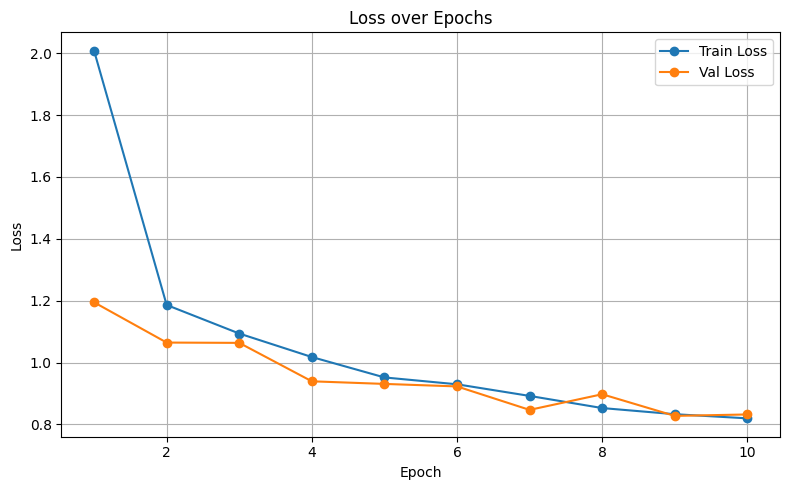

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

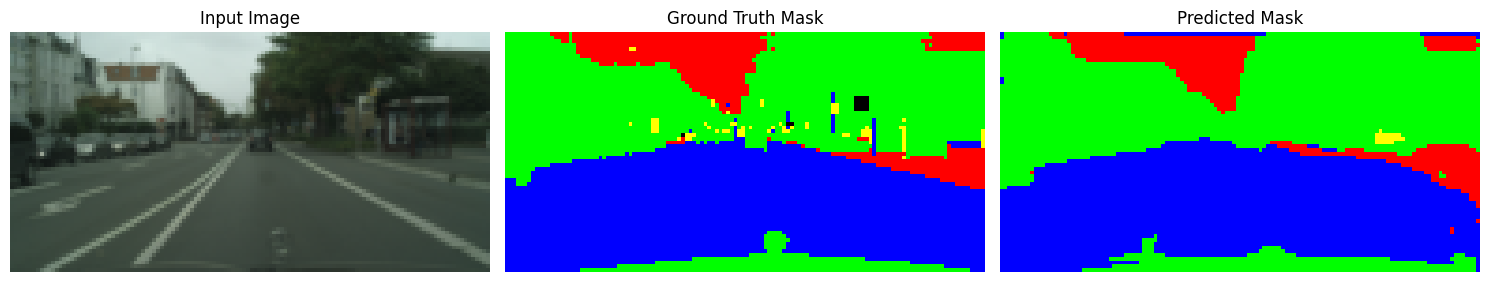

In [6]:
import numpy as np
import torch

model.eval()
with torch.no_grad():
    sample_image, sample_target = next(iter(val_loader))
    sample_image = sample_image.to(device)
    sample_target = sample_target.to(device)

    output = model(sample_image)
    pred_mask = torch.argmax(output, dim=1)

img = sample_image[0].cpu().permute(1, 2, 0).numpy()
gt_mask = sample_target[0].cpu().squeeze().numpy()
pred_mask = pred_mask[0].cpu().numpy()

def apply_colormap(mask):
    colormap = np.array([
        [0, 0, 0],         # class 0: black
        [0, 255, 0],       # class 1: green
        [0, 0, 255],       # class 2: blue
        [255, 0, 0],       # class 3: red
        [255, 255, 0],     # etc.
    ])
    mask_rgb = colormap[mask % len(colormap)]
    return mask_rgb.astype(np.uint8)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img)
axs[0].set_title("Input Image")
axs[1].imshow(apply_colormap(gt_mask))
axs[1].set_title("Ground Truth Mask")
axs[2].imshow(apply_colormap(pred_mask))
axs[2].set_title("Predicted Mask")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
torch.save(model.state_dict(), "./weights/cityscapes_unet.pth")

# Ensemble

In [8]:
num_classes = 34

model1 = UNet(in_channels=3, out_channels=num_classes).to(device)
model2 = UNet(in_channels=3, out_channels=num_classes).to(device)
model3 = UNet(in_channels=3, out_channels=num_classes).to(device)

ensemble_models = [model1, model2, model3]

In [9]:
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-3)

ensemble_optimizers = [optimizer1, optimizer2, optimizer3]

In [10]:
from tqdm import tqdm

def train_one_epoch_ensemble(models, optimizers, loader, criterion):
    for model in models:
        model.train()

    total_loss = 0

    for images, targets in tqdm(loader, desc="Training"):
        images = images.to(device)
        targets = targets.to(device).long().squeeze(1)

        batch_loss = 0

        for model, optimizer in zip(models, optimizers):
            outputs = model(images)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss += loss.item()

        total_loss += batch_loss / len(models)  # Average loss over ensemble

    return total_loss / len(loader)


def validate_ensemble(models, loader, criterion):
    for model in models:
        model.eval()

    total_loss = 0

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device).long().squeeze(1)

            # Get ensemble predictions (softmax average)
            outputs = [torch.softmax(model(images), dim=1) for model in models]
            avg_output = torch.stack(outputs).mean(dim=0)

            loss = criterion(avg_output, targets)
            total_loss += loss.item()

    return total_loss / len(loader)

In [11]:
num_epochs = 1
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_one_epoch_ensemble(ensemble_models, ensemble_optimizers, train_loader, criterion)
    val_loss = validate_ensemble(ensemble_models, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/1


Training: 100%|██████████| 200/200 [01:27<00:00,  2.29it/s]


Train Loss: 1.9578 | Val Loss: 3.0938


In [12]:
for i, model in enumerate(ensemble_models):
    torch.save(model.state_dict(), f"./weights/cityscapes_ensemble_unet_{i+1}.pth")

# Predicting masks for a normal sample, and for two samples that were adversarially attacked

/var/folders/b6/486jxbhd03z06w9634qqg4km0000gn/T/ipykernel_13746/382538662.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  single_unet.load_state_dict(torch.load("./weig

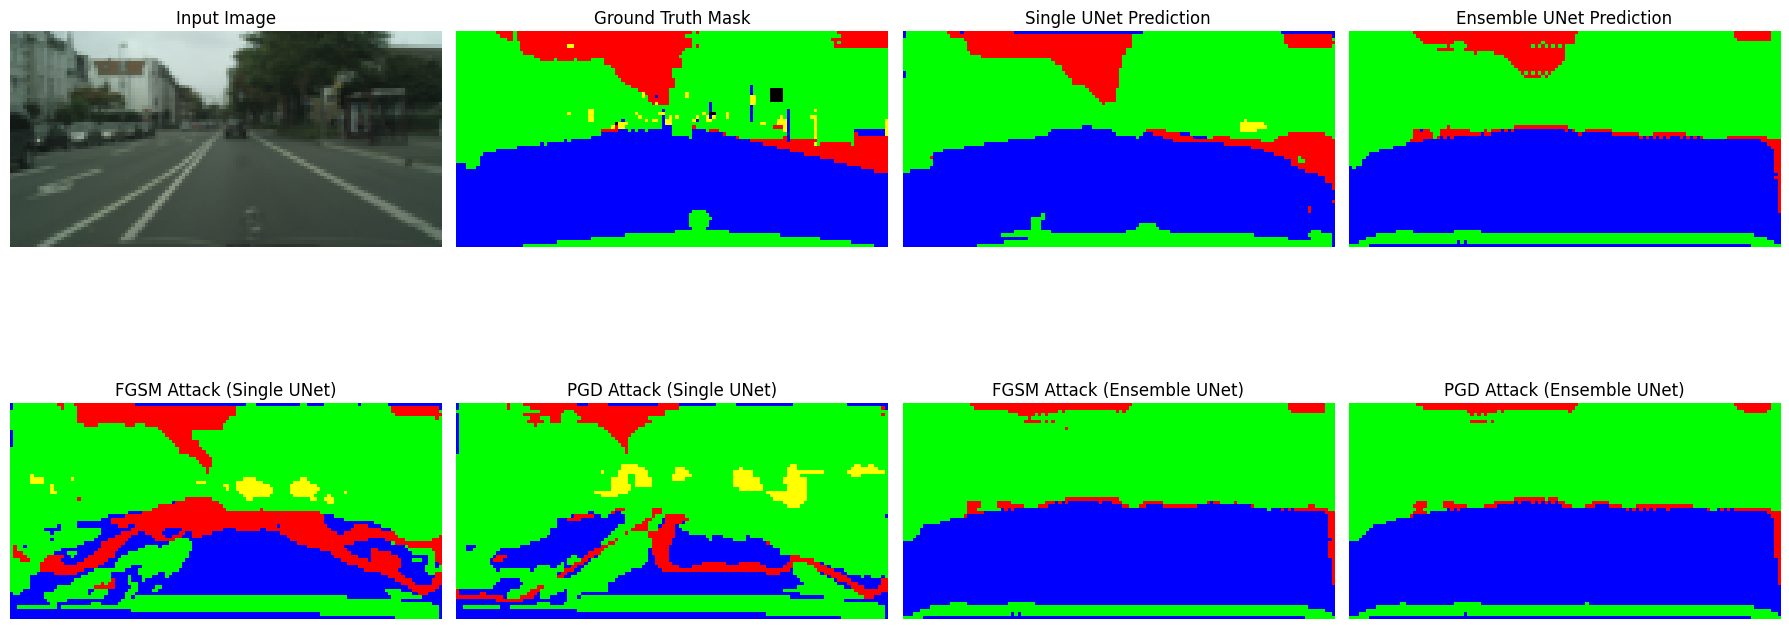

In [22]:
import torch
import torchattacks
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Load the Single UNet
single_unet = UNet(in_channels=3, out_channels=34)  # Assuming 19 classes for Cityscapes
single_unet.load_state_dict(torch.load("./weights/cityscapes_unet.pth"))
single_unet.to(device)
single_unet.eval()

# Load the Ensemble of UNets
ensemble_models = []
for i in range(3):  # Assuming an ensemble of 3 models
    ensemble_model = UNet(in_channels=3, out_channels=34)
    ensemble_model.load_state_dict(torch.load(f"./weights/cityscapes_ensemble_unet_{i+1}.pth"))
    ensemble_model.to(device)
    ensemble_model.eval()
    ensemble_models.append(ensemble_model)

def apply_colormap(mask):
    colormap = np.array([
        [0, 0, 0],         # class 0: black
        [0, 255, 0],       # class 1: green
        [0, 0, 255],       # class 2: blue
        [255, 0, 0],       # class 3: red
        [255, 255, 0],     # etc.
    ])
    mask_rgb = colormap[mask % len(colormap)]
    return mask_rgb.astype(np.uint8)

# Load a sample from the validation loader
sample_image, sample_target = next(iter(val_loader))
sample_image = sample_image.to(device)
sample_target = sample_target.to(device).long().squeeze(1)

# Step 2: Predict the mask with the single UNet
with torch.no_grad():
    single_unet_output = single_unet(sample_image)
    single_unet_pred = torch.argmax(single_unet_output, dim=1)

# Step 3: Predict the mask with the ensemble UNet
ensemble_preds = [torch.softmax(m(sample_image), dim=1) for m in ensemble_models]
ensemble_avg_pred = torch.stack(ensemble_preds).mean(dim=0)
ensemble_pred = torch.argmax(ensemble_avg_pred, dim=1)

# Step 4: Apply FGSM and PGD attacks on the sample
fgsm = torchattacks.FGSM(single_unet, eps=0.02)
pgd = torchattacks.PGD(single_unet, eps=0.02, alpha=0.01, steps=40)

# FGSM attack
sample_fgsm = fgsm(sample_image, sample_target)

# PGD attack
sample_pgd = pgd(sample_image, sample_target)

# Step 5: Predict the mask for the attacked sample using the single UNet
with torch.no_grad():
    fgsm_single_output = single_unet(sample_fgsm)
    fgsm_single_pred = torch.argmax(fgsm_single_output, dim=1)

    pgd_single_output = single_unet(sample_pgd)
    pgd_single_pred = torch.argmax(pgd_single_output, dim=1)

# Step 6: Predict the mask for the attacked sample using the ensemble UNet
fgsm_ensemble_preds = [torch.softmax(m(sample_fgsm), dim=1) for m in ensemble_models]
fgsm_ensemble_avg_pred = torch.stack(fgsm_ensemble_preds).mean(dim=0)
fgsm_ensemble_pred = torch.argmax(fgsm_ensemble_avg_pred, dim=1)

pgd_ensemble_preds = [torch.softmax(m(sample_pgd), dim=1) for m in ensemble_models]
pgd_ensemble_avg_pred = torch.stack(pgd_ensemble_preds).mean(dim=0)
pgd_ensemble_pred = torch.argmax(pgd_ensemble_avg_pred, dim=1)

# Step 7: Plot the images side by side
img = sample_image[0].cpu().permute(1, 2, 0).numpy()
gt_mask = sample_target[0].cpu().squeeze().numpy()
single_unet_mask = single_unet_pred[0].cpu().numpy()
ensemble_mask = ensemble_pred[0].cpu().numpy()
fgsm_single_mask = fgsm_single_pred[0].cpu().numpy()
pgd_single_mask = pgd_single_pred[0].cpu().numpy()
fgsm_ensemble_mask = fgsm_ensemble_pred[0].cpu().numpy()
pgd_ensemble_mask = pgd_ensemble_pred[0].cpu().numpy()

# Plotting side by side
fig, axs = plt.subplots(2, 4, figsize=(18, 9))

# Original Image
axs[0, 0].imshow(img)
axs[0, 0].set_title("Input Image")
axs[0, 0].axis('off')

# Ground Truth Mask
axs[0, 1].imshow(apply_colormap(gt_mask))
axs[0, 1].set_title("Ground Truth Mask")
axs[0, 1].axis('off')

# Mask with Single UNet
axs[0, 2].imshow(apply_colormap(single_unet_mask))
axs[0, 2].set_title("Single UNet Prediction")
axs[0, 2].axis('off')

# Mask with Ensemble UNet
axs[0, 3].imshow(apply_colormap(ensemble_mask))
axs[0, 3].set_title("Ensemble UNet Prediction")
axs[0, 3].axis('off')

# Mask with FGSM Attack and Single UNet
axs[1, 0].imshow(apply_colormap(fgsm_single_mask))
axs[1, 0].set_title("FGSM Attack (Single UNet)")
axs[1, 0].axis('off')

# Mask with PGD Attack and Single UNet
axs[1, 1].imshow(apply_colormap(pgd_single_mask))
axs[1, 1].set_title("PGD Attack (Single UNet)")
axs[1, 1].axis('off')

# Mask with FGSM Attack and Ensemble UNet
axs[1, 2].imshow(apply_colormap(fgsm_ensemble_mask))
axs[1, 2].set_title("FGSM Attack (Ensemble UNet)")
axs[1, 2].axis('off')

# Mask with PGD Attack and Ensemble UNet
axs[1, 3].imshow(apply_colormap(pgd_ensemble_mask))
axs[1, 3].set_title("PGD Attack (Ensemble UNet)")
axs[1, 3].axis('off')

plt.tight_layout()
plt.show()
